In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # Separación dataset
from sklearn import metrics # Metricas para la evaluación
from sklearn.neighbors import LocalOutlierFactor

#Creación de modelos
from sklearn import svm
from sklearn import neighbors
from sklearn.naive_bayes import ComplementNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 8))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=40,ax=ax, facecolor='midnightblue', edgecolor='black')
        title_obj = ax.set_title(var_name+" Distribution")
        plt.setp(title_obj, color='black')                     # Individual title colours.

        # remove grid lines
        ax.grid(False)

        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.tick_params(axis='x', colors='black')       #set the color of xticks
        ax.tick_params(axis='y', colors='black')       #set the color of yticks

    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


In [3]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('/content/Preprocessed.csv')
d.head(10)

,Incumplimiento,TasaUtilizacionLineasRotativas,Edad,Mora30a59dias,RazonDeudaMensual,IngresoMensual,CantidadCreditosActivos,MoraMayorA90,CantidadCreditosDeVivienda,Mora60a89dias,CantidadDependientes,OcurrenciasMora
0,1,0.766127,0.272727,0.153846,0.000201,0.45600,0.228070,0.000000,0.30,0.0,0.50,2
1,0,0.957151,0.215909,0.000000,0.000030,0.13000,0.070175,0.000000,0.00,0.0,0.25,0
2,0,0.658180,0.193182,0.076923,0.000021,0.15210,0.035088,0.058824,0.00,0.0,0.00,2
3,0,0.233810,0.102273,0.000000,0.000009,0.16500,0.087719,0.000000,0.00,0.0,0.00,0
4,0,0.213179,0.602273,0.000000,0.000094,0.17500,0.052632,0.000000,0.05,0.0,0.25,0
5,0,0.754464,0.204545,0.000000,0.000052,0.17500,0.140351,0.000000,0.00,0.0,0.00,0
6,0,0.116951,0.068182,0.000000,0.011500,0.27080,0.035088,0.000000,0.00,0.0,0.00,0
7,0,0.644226,0.102273,0.000000,0.000077,0.12500,0.087719,0.000000,0.00,0.0,0.00,0
8,0,0.018798,0.340909,0.000000,0.000133,0.32505,0.122807,0.000000,0.10,0.0,0.50,0
9,0,0.010352,0.284091,0.000000,0.000075,0.62270,0.228070,0.000000,0.10,0.0,0.50,0


In [4]:
d.describe()

,Incumplimiento,TasaUtilizacionLineasRotativas,Edad,Mora30a59dias,RazonDeudaMensual,IngresoMensual,CantidadCreditosActivos,MoraMayorA90,CantidadCreditosDeVivienda,Mora60a89dias,CantidadDependientes,OcurrenciasMora
count,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000
mean,0.058867,0.301405,0.358040,0.017372,0.060150,0.297039,0.147343,0.004643,0.049041,0.005151,0.174893,0.361442
std,0.235376,0.337377,0.169160,0.050873,0.172924,0.167179,0.089137,0.026077,0.052463,0.027586,0.258636,1.016653
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.027972,0.227273,0.000000,0.000044,0.192500,0.087719,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.141092,0.352273,0.000000,0.000091,0.270800,0.140351,0.000000,0.050000,0.000000,0.000000,0.000000
75%,0.000000,0.514463,0.477273,0.000000,0.000202,0.364537,0.192982,0.000000,0.100000,0.000000,0.250000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.000000


In [5]:
#dividiendo el df en entradas y salidas
X = d.drop(columns=['Incumplimiento'])
y = d['Incumplimiento']

In [6]:
# Se hace la separación del dataset para entrenamiento y evaluación.
# 30% sería para evaluación y 70% para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y.values.reshape(-1,1),
    train_size = 0.7,
    random_state=282,
    shuffle=True
)

In [7]:
# Entrenamiento de multiples modelos

# Maquinas de soporte vectorial
modelSVC       = svm.SVC(kernel='linear', probability = True).fit(X_train, y_train)
# Regresión logistica
modelLR        = LogisticRegression(random_state=0).fit(X_train, y_train)
# Clasificador de K Neighbors
modelknn       = neighbors.KNeighborsClassifier(n_neighbors = 31).fit(X_train, y_train)
# Complemento del Naive Bayes
modelComplNB   = ComplementNB().fit(X_train, y_train)
# Arboles de decision
modelTreeClas  = tree.DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
# Gradient Boosting
modelGD = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05,
                                     max_depth=5, random_state=231) \
                                     .fit(X_train, y_train)
# Random forest
modelRanForest = RandomForestClassifier(n_estimators=100, max_depth=5, max_features = 'auto', criterion = 'gini', random_state=0).fit(X_train, y_train)
# Redes neuronales - Prospectos
ModelNN        = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2), random_state=0).fit(X_train, y_train)
# ModelXGB
modelXGB = XGBClassifier( n_estimators = 150, learning_rate=0.05, max_depth = 5) \
                .fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

0.70: SVC(kernel='linear', probability=True)
0.84: LogisticRegression(random_state=0)
0.89: KNeighborsClassifier(n_neighbors=31)
0.79: ComplementNB()
0.85: RandomForestClassifier(max_depth=5, max_features='auto', random_state=0)
0.87: GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=150,
                           random_state=231)
0.87: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
          

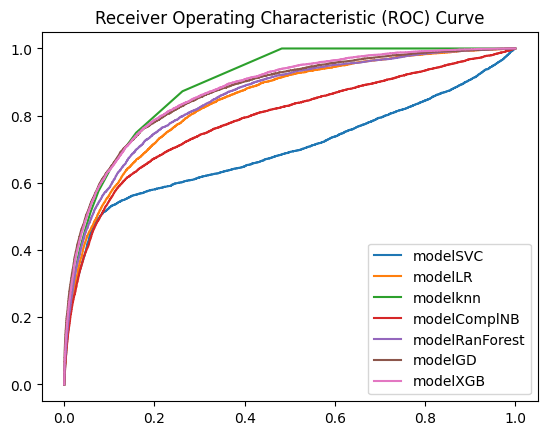

In [8]:
models = [
    ('modelSVC', modelSVC),
    ('modelLR', modelLR),
    ('modelknn', modelknn),
    ('modelComplNB', modelComplNB),
    ('modelRanForest', modelRanForest),
    ('modelGD', modelGD),
    ('modelXGB', modelXGB)
]

for name, model in models:
    # aqui se hace la curva roc con X_train
    prob = model.predict_proba(X_train)
    preds = prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
    auc = metrics.auc(fpr, tpr)
    print("{:.2f}: {}".format(auc, model))
    plt.plot(fpr, tpr, label=name)

plt.title('Receiver Operating Characteristic (ROC) Curve')  # Título del gráfico
plt.legend()  # Mostrar la leyenda de los modelos
plt.show()  # Mostrar el gráfico

In [11]:
# Validación cruzada en todos los modelos
cv = 6
scoring = ['accuracy', 'precision', 'recall', 'f1']

models = [
    ('modelRanForest', modelRanForest),
    ('modelknn',modelknn),
    ('modelGD', modelGD),
    ('modelXGB', modelXGB)
]

cv_df = pd.DataFrame()

for name, model in models:
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    model_scores = pd.DataFrame(scores)
    model_scores['model_name'] = name
    cv_df = pd.concat([cv_df, model_scores], ignore_index=True)

column_order = ['model_name', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
cv_df = cv_df.reindex(columns=column_order)

cv_df

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

,model_name,test_accuracy,test_precision,test_recall,test_f1
0,modelRanForest,0.942874,0.603015,0.086894,0.151899
1,modelRanForest,0.942917,0.600000,0.091238,0.158391
2,modelRanForest,0.943087,0.613861,0.089790,0.156665
3,modelRanForest,0.942874,0.609626,0.082549,0.145408
4,modelRanForest,0.944579,0.728814,0.093411,0.165597
5,modelRanForest,0.943087,0.605634,0.093478,0.161959
6,modelknn,0.942235,0.539634,0.128168,0.207139
7,modelknn,0.942320,0.541176,0.133237,0.213829
8,modelknn,0.941595,0.517460,0.118030,0.192217
9,modelknn,0.942533,0.556314,0.118030,0.194743


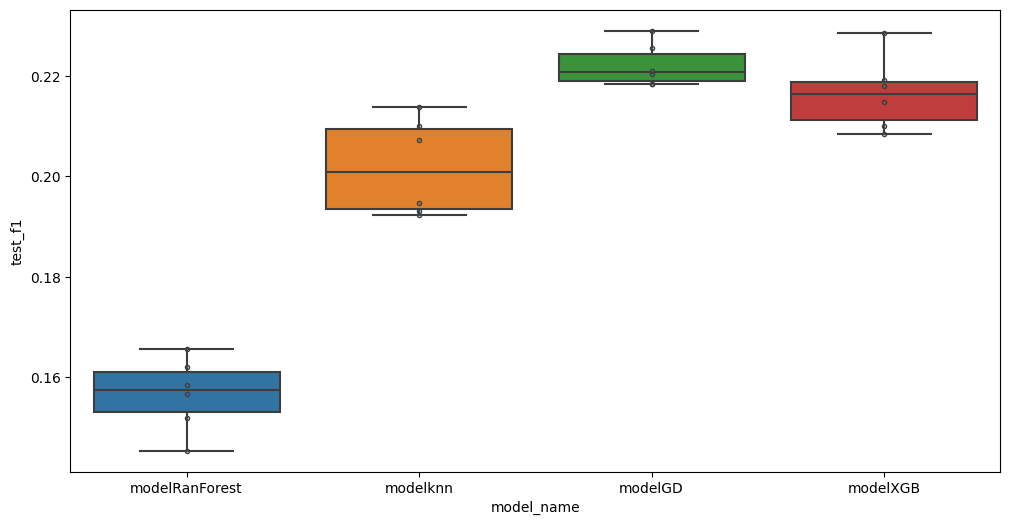

In [12]:
# Gráfica de f1-score de los modelos

fig = plt.figure(figsize=(12,6))

sns.boxplot(x='model_name', y='test_f1', data=cv_df)
sns.stripplot(x='model_name', y='test_f1', data=cv_df,
              size=1, jitter=False, edgecolor="gray", linewidth=3)
plt.show()